# Bachelor Thesis: Predicting flight delays
#### Author: Tygo Francissen, s1049742, Radboud University
This thesis aims to predict flight delays in the United States and Brazil by using a broad scale of machine learning algorithms and transfer learning.

### 1 Gathering the data
The data sets are gathered from the [Bureau of Transportation Statistics](https://www.transtats.bts.gov) and the [VRA](https://sas.anac.gov.br/sas/bav/view/frmConsultaVRA). Firstly, we store the data, which ranges from January 1st 2022 until January 31st 2022 for both data sets.

In [2]:
# All imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from deep_translator import GoogleTranslator
from pandas.api.types import is_numeric_dtype
from sklearn.feature_selection import chi2, mutual_info_classif

In [3]:
# Store the data sets for January 2022
data_brazil = pd.read_excel('../Data/VRA_20230228124648.xlsx')
data_usa = pd.read_csv('../Data/T_ONTIME_REPORTING.csv')

### 2 Preprocessing the Brazilian data

We will preprocess both data sets separately, but trying to keep the information in both data sets match each other where possible. The first data set to be preprocessed is the Brazilian data set.

#### 2.1 Looking at the data

Let's have a look at the data first before modifying it.

In [4]:
display(data_brazil)

,Sigla ICAO Empresa Aérea,Empresa Aérea,Número Voo,Código DI,Código Tipo Linha,Modelo Equipamento,Número de Assentos,Sigla ICAO Aeroporto Origem,Descrição Aeroporto Origem,Partida Prevista,Partida Real,Sigla ICAO Aeroporto Destino,Descrição Aeroporto Destino,Chegada Prevista,Chegada Real,Situação Voo,Justificativa,Referência,Situação Partida,Situação Chegada
0,AAL,"AMERICAN AIRLINES, INC.",904,0,I,B788,295,SBGL,AEROPORTO INTERNACIONAL DO RIO DE JANEIRO (GAL...,2022-01-01 00:05:00,NaT,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-01 08:50:00,NaT,CANCELADO,NaN,2022-01-01,NaN,NaN
1,AAL,"AMERICAN AIRLINES, INC.",905,0,I,B788,295,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-01 22:00:00,NaT,SBGL,AEROPORTO INTERNACIONAL DO RIO DE JANEIRO (GAL...,2022-01-02 06:20:00,NaT,CANCELADO,NaN,2022-01-01,NaN,NaN
2,AAL,"AMERICAN AIRLINES, INC.",906,0,I,B77W,318,SBGR,GUARULHOS - GOVERNADOR ANDRÉ FRANCO MONTORO - ...,2022-01-01 00:05:00,NaT,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-01 08:40:00,NaT,CANCELADO,NaN,2022-01-01,NaN,NaN
3,AAL,"AMERICAN AIRLINES, INC.",929,0,I,B77W,318,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-01 22:00:00,NaT,SBGR,GUARULHOS - GOVERNADOR ANDRÉ FRANCO MONTORO - ...,2022-01-02 06:20:00,NaT,CANCELADO,NaN,2022-01-01,NaN,NaN
4,AAL,"AMERICAN AIRLINES, INC.",930,0,I,B788,295,SBGR,GUARULHOS - GOVERNADOR ANDRÉ FRANCO MONTORO - ...,2022-01-01 22:30:00,NaT,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-02 06:55:00,NaT,CANCELADO,NaN,2022-01-01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70663,UPS,UPS - UNITED PARCEL SERVICE CO.,444,0,X,B763,0,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-30 08:10:00,2022-01-30 09:17:00,SBKP,VIRACOPOS - CAMPINAS - SP - BRASIL,2022-01-30 16:10:00,2022-01-30 17:18:00,REALIZADO,NaN,2022-01-30,Atraso 60-120,Atraso 60-120
70664,UPS,UPS - UNITED PARCEL SERVICE CO.,445,0,X,B763,0,SBKP,VIRACOPOS - CAMPINAS - SP - BRASIL,2022-01-30 17:40:00,2022-01-30 18:26:00,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-31 01:30:00,2022-01-31 02:30:00,REALIZADO,NaN,2022-01-30,Atraso 30-60,Atraso 30-60
70665,UPS,UPS - UNITED PARCEL SERVICE CO.,417,0,X,B763,0,SKBO,EL DORADO INTERNATIONAL AIRPORT - BOGOTÁ - COL...,2022-02-01 07:50:00,2022-02-01 07:24:00,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-02-01 11:25:00,2022-02-01 11:08:00,REALIZADO,NaN,2022-01-31,Antecipado,Antecipado
70666,UPS,UPS - UNITED PARCEL SERVICE CO.,417,0,X,B763,0,SAEZ,MINISTRO PISTARINI INTERNATIONAL AIRPORT (EZEI...,2022-01-31 20:10:00,2022-01-31 19:34:00,SBKP,VIRACOPOS - CAMPINAS - SP - BRASIL,2022-01-31 22:40:00,2022-01-31 22:04:00,REALIZADO,NaN,2022-01-31,Antecipado,Antecipado


The Brazilian data set is written in Brazilian language, while the author is unable to read this language. Therefore, we translate the column names of the Brazilian data set into English text. To increase readability of the data, two lookup dictionaries for the airline and airport ICAO code are created (and translated).

In [5]:
# Translate the column names of the Brazilian data set
translator = GoogleTranslator(source='auto', target='en')
for i, _ in enumerate(data_brazil.columns.values):
    data_brazil.rename(columns={data_brazil.columns.values[i]:translator.translate(data_brazil.columns.values[i])}, inplace=True)
    
# Create dictionary to look up full name of airline ICAO code
values = [translator.translate(name) for name in data_brazil["airline"].unique()]
airline_code_dict = dict(zip(data_brazil["Acronym ICAO Airline"].unique(), values))

# Create dictionary to look up full name of airport ICAO code
keys = pd.unique(np.concatenate((data_brazil["Acronym ICAO Airport Origin"].unique(),data_brazil["Acronym ICAO Destiny Airport"].unique())))
airports = pd.unique(np.concatenate((data_brazil["Description Origin Airport"].unique(),data_brazil["Destination Airport Description"].unique())))
values = [translator.translate(name) for name in airports]
airport_code_dict = dict(zip(keys, values))

Since some columns still contain Brazilian words, the remaining words are translated to English.

In [6]:
# Translate remaining Brazilian words in data set
for word in data_brazil["Flight Status"].unique():
    data_brazil["Flight Status"] = data_brazil["Flight Status"].replace(word, translator.translate(word))

for word in data_brazil["Starting Status"].unique():
    if not type(word)==float:
        data_brazil["Starting Status"] = data_brazil["Starting Status"].replace(word, translator.translate(word))

for word in data_brazil["Arrival Status"].unique():
    if not type(word)==float:
        data_brazil["Arrival Status"] = data_brazil["Arrival Status"].replace(word, translator.translate(word))

Now that all text has been properly translated, we can have a look at the data again.

In [7]:
display(data_brazil)

,Acronym ICAO Airline,airline,Flight Number,Code DI,Line Type Code,Model Equipment,Number of Seats,Acronym ICAO Airport Origin,Description Origin Airport,Scheduled departure,actual match,Acronym ICAO Destiny Airport,Destination Airport Description,Expected Arrival,actual arrival,Flight Status,Justification,Reference,Starting Status,Arrival Status
0,AAL,"AMERICAN AIRLINES, INC.",904,0,I,B788,295,SBGL,AEROPORTO INTERNACIONAL DO RIO DE JANEIRO (GAL...,2022-01-01 00:05:00,NaT,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-01 08:50:00,NaT,CANCELED,NaN,2022-01-01,NaN,NaN
1,AAL,"AMERICAN AIRLINES, INC.",905,0,I,B788,295,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-01 22:00:00,NaT,SBGL,AEROPORTO INTERNACIONAL DO RIO DE JANEIRO (GAL...,2022-01-02 06:20:00,NaT,CANCELED,NaN,2022-01-01,NaN,NaN
2,AAL,"AMERICAN AIRLINES, INC.",906,0,I,B77W,318,SBGR,GUARULHOS - GOVERNADOR ANDRÉ FRANCO MONTORO - ...,2022-01-01 00:05:00,NaT,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-01 08:40:00,NaT,CANCELED,NaN,2022-01-01,NaN,NaN
3,AAL,"AMERICAN AIRLINES, INC.",929,0,I,B77W,318,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-01 22:00:00,NaT,SBGR,GUARULHOS - GOVERNADOR ANDRÉ FRANCO MONTORO - ...,2022-01-02 06:20:00,NaT,CANCELED,NaN,2022-01-01,NaN,NaN
4,AAL,"AMERICAN AIRLINES, INC.",930,0,I,B788,295,SBGR,GUARULHOS - GOVERNADOR ANDRÉ FRANCO MONTORO - ...,2022-01-01 22:30:00,NaT,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-02 06:55:00,NaT,CANCELED,NaN,2022-01-01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70663,UPS,UPS - UNITED PARCEL SERVICE CO.,444,0,X,B763,0,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-30 08:10:00,2022-01-30 09:17:00,SBKP,VIRACOPOS - CAMPINAS - SP - BRASIL,2022-01-30 16:10:00,2022-01-30 17:18:00,ACCOMPLISHED,NaN,2022-01-30,Delay 60-120,Delay 60-120
70664,UPS,UPS - UNITED PARCEL SERVICE CO.,445,0,X,B763,0,SBKP,VIRACOPOS - CAMPINAS - SP - BRASIL,2022-01-30 17:40:00,2022-01-30 18:26:00,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-31 01:30:00,2022-01-31 02:30:00,ACCOMPLISHED,NaN,2022-01-30,Delay 30-60,Delay 30-60
70665,UPS,UPS - UNITED PARCEL SERVICE CO.,417,0,X,B763,0,SKBO,EL DORADO INTERNATIONAL AIRPORT - BOGOTÁ - COL...,2022-02-01 07:50:00,2022-02-01 07:24:00,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-02-01 11:25:00,2022-02-01 11:08:00,ACCOMPLISHED,NaN,2022-01-31,anticipated,anticipated
70666,UPS,UPS - UNITED PARCEL SERVICE CO.,417,0,X,B763,0,SAEZ,MINISTRO PISTARINI INTERNATIONAL AIRPORT (EZEI...,2022-01-31 20:10:00,2022-01-31 19:34:00,SBKP,VIRACOPOS - CAMPINAS - SP - BRASIL,2022-01-31 22:40:00,2022-01-31 22:04:00,ACCOMPLISHED,NaN,2022-01-31,anticipated,anticipated


Since we created lookup dictionaries for the airline and airport ICAO code, the columns 'airline', 'Description Origin Airport', and 'Destination Airport Description' can be removed.

In [8]:
# Remove redundant columns
data_brazil2 = data_brazil.drop(columns=['airline', 'Description Origin Airport', 'Destination Airport Description'])
display(data_brazil2)

,Acronym ICAO Airline,Flight Number,Code DI,Line Type Code,Model Equipment,Number of Seats,Acronym ICAO Airport Origin,Scheduled departure,actual match,Acronym ICAO Destiny Airport,Expected Arrival,actual arrival,Flight Status,Justification,Reference,Starting Status,Arrival Status
0,AAL,904,0,I,B788,295,SBGL,2022-01-01 00:05:00,NaT,KMIA,2022-01-01 08:50:00,NaT,CANCELED,NaN,2022-01-01,NaN,NaN
1,AAL,905,0,I,B788,295,KMIA,2022-01-01 22:00:00,NaT,SBGL,2022-01-02 06:20:00,NaT,CANCELED,NaN,2022-01-01,NaN,NaN
2,AAL,906,0,I,B77W,318,SBGR,2022-01-01 00:05:00,NaT,KMIA,2022-01-01 08:40:00,NaT,CANCELED,NaN,2022-01-01,NaN,NaN
3,AAL,929,0,I,B77W,318,KMIA,2022-01-01 22:00:00,NaT,SBGR,2022-01-02 06:20:00,NaT,CANCELED,NaN,2022-01-01,NaN,NaN
4,AAL,930,0,I,B788,295,SBGR,2022-01-01 22:30:00,NaT,KMIA,2022-01-02 06:55:00,NaT,CANCELED,NaN,2022-01-01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70663,UPS,444,0,X,B763,0,KMIA,2022-01-30 08:10:00,2022-01-30 09:17:00,SBKP,2022-01-30 16:10:00,2022-01-30 17:18:00,ACCOMPLISHED,NaN,2022-01-30,Delay 60-120,Delay 60-120
70664,UPS,445,0,X,B763,0,SBKP,2022-01-30 17:40:00,2022-01-30 18:26:00,KMIA,2022-01-31 01:30:00,2022-01-31 02:30:00,ACCOMPLISHED,NaN,2022-01-30,Delay 30-60,Delay 30-60
70665,UPS,417,0,X,B763,0,SKBO,2022-02-01 07:50:00,2022-02-01 07:24:00,KMIA,2022-02-01 11:25:00,2022-02-01 11:08:00,ACCOMPLISHED,NaN,2022-01-31,anticipated,anticipated
70666,UPS,417,0,X,B763,0,SAEZ,2022-01-31 20:10:00,2022-01-31 19:34:00,SBKP,2022-01-31 22:40:00,2022-01-31 22:04:00,ACCOMPLISHED,NaN,2022-01-31,anticipated,anticipated


#### 2.2 First steps of data cleaning
Now that the data set has been made more readable, we can start having a look at the values of the columns and its properties.

In [9]:
print(data_brazil2.count())

Acronym ICAO Airline            70668
Flight Number                   70668
Code DI                         70668
Line Type Code                  70668
Model Equipment                 70668
Number of Seats                 70668
Acronym ICAO Airport Origin     70668
Scheduled departure             70668
actual match                    66291
Acronym ICAO Destiny Airport    70668
Expected Arrival                70668
actual arrival                  66291
Flight Status                   70668
Justification                       0
Reference                       70668
Starting Status                 66291
Arrival Status                  66291
dtype: int64


The justification column has no record, thus it will be removed.

In [10]:
# Drop justification column as it has no entries
data_brazil2.drop(columns=['Justification'], inplace=True)

If we look at the flight status column, it can be seen that there are 3 possible options: cancelled, uninformed and accomplished. Since we are only interested in flight delays, we will only look at flights that have been accomplished. That leaves this column with only one possible value, so the column can be removed as well.

In [11]:
# Drop entries of flights that are cancelled or uninformed
data_brazil3 = data_brazil2.drop(data_brazil2[(data_brazil2["Flight Status"] == "CANCELED") | (data_brazil2["Flight Status"] == "UNINFORMED")].index)

# Drop flight status column as it has no use anymore
data_brazil3.drop(columns=['Flight Status'], inplace=True)

To create our response variable, we are calculating the total delay of each flight. The total delay is calculated by adding the arrival delay to the departure delay. If the total delay is more than 15 minutes, the flight is considered delayed. We create 3 response variables here, for eventual use cases later in the research.

In [12]:
# Change starting status column to represent whether the departure delay is more than 15 minutes
data_brazil3.loc[(data_brazil3["actual match"]-data_brazil3["Scheduled departure"]) <= datetime.timedelta(minutes=15), "Starting Status"] = 0
data_brazil3.loc[(data_brazil3["actual match"]-data_brazil3["Scheduled departure"]) > datetime.timedelta(minutes=15), "Starting Status"] = 1

# Change arrival status column to represent whether the arrival delay is more than 15 minutes
data_brazil3.loc[(data_brazil3["actual arrival"]-data_brazil3["Expected Arrival"]) <= datetime.timedelta(minutes=15), "Arrival Status"] = 0
data_brazil3.loc[(data_brazil3["actual arrival"]-data_brazil3["Expected Arrival"]) > datetime.timedelta(minutes=15), "Arrival Status"] = 1

# Create new column "Delayed" which represents whether the total delay of the flight is more than 15 minutes
data_brazil3.reset_index(drop=True, inplace=True)
data_brazil3.loc[(data_brazil3["actual match"]-data_brazil3["Scheduled departure"]) + (data_brazil3["actual arrival"]-data_brazil3["Expected Arrival"]) <= datetime.timedelta(minutes=15), "Delayed"] = 0
data_brazil3.loc[(data_brazil3["actual match"]-data_brazil3["Scheduled departure"]) + (data_brazil3["actual arrival"]-data_brazil3["Expected Arrival"]) > datetime.timedelta(minutes=15), "Delayed"] = 1
data_brazil3["Delayed"] = data_brazil3["Delayed"].astype(int)

display(data_brazil3)

,Acronym ICAO Airline,Flight Number,Code DI,Line Type Code,Model Equipment,Number of Seats,Acronym ICAO Airport Origin,Scheduled departure,actual match,Acronym ICAO Destiny Airport,Expected Arrival,actual arrival,Reference,Starting Status,Arrival Status,Delayed
0,ACA,90,0,X,B773,450,CYYZ,2022-01-01 00:50:00,2022-01-01 01:32:00,SBGR,2022-01-01 10:50:00,2022-01-01 10:51:00,2022-01-01,1,0,1
1,ACA,91,0,X,B773,450,SBGR,2022-01-01 20:45:00,2022-01-01 21:04:00,CYYZ,2022-01-02 06:45:00,2022-01-02 07:07:00,2022-01-01,1,1,1
2,ACA,97,0,X,B789,300,SAEZ,2022-01-01 16:45:00,2022-01-01 17:34:00,SBGR,2022-01-01 19:45:00,2022-01-01 20:13:00,2022-01-01,1,1,1
3,ACA,97,0,X,B789,300,SBGR,2022-01-01 22:00:00,2022-01-01 22:10:00,CYUL,2022-01-02 08:00:00,2022-01-02 08:24:00,2022-01-01,0,1,1
4,ACA,90,0,X,B773,450,CYYZ,2022-01-02 00:50:00,2022-01-02 04:59:00,SBGR,2022-01-02 10:50:00,2022-01-02 14:59:00,2022-01-02,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66286,UPS,444,0,X,B763,0,KMIA,2022-01-30 08:10:00,2022-01-30 09:17:00,SBKP,2022-01-30 16:10:00,2022-01-30 17:18:00,2022-01-30,1,1,1
66287,UPS,445,0,X,B763,0,SBKP,2022-01-30 17:40:00,2022-01-30 18:26:00,KMIA,2022-01-31 01:30:00,2022-01-31 02:30:00,2022-01-30,1,1,1
66288,UPS,417,0,X,B763,0,SKBO,2022-02-01 07:50:00,2022-02-01 07:24:00,KMIA,2022-02-01 11:25:00,2022-02-01 11:08:00,2022-01-31,0,0,0
66289,UPS,417,0,X,B763,0,SAEZ,2022-01-31 20:10:00,2022-01-31 19:34:00,SBKP,2022-01-31 22:40:00,2022-01-31 22:04:00,2022-01-31,0,0,0


It's useful for the machine learning algorithms to split up the departure date and expected arrival. Therefore, we split the departure date into year, month, week, day, hour, minute and day of the week. The expected arrival is split into hour and minute, to avoid high collinearity since most flights arrive at the same day. Also, the data is ordered on their departure date, and a couple of entries seem to fall outside the month January, which is the reason they got removed.

In [13]:
# Create new columns to split up the departure date
data_brazil3["SchedDeparture_year"] = data_brazil3["Scheduled departure"].dt.year
data_brazil3["SchedDeparture_month"] = data_brazil3["Scheduled departure"].dt.month
data_brazil3["SchedDeparture_week"] = data_brazil3["Scheduled departure"].dt.isocalendar().week
data_brazil3["SchedDeparture_day"] = data_brazil3["Scheduled departure"].dt.day
data_brazil3["SchedDeparture_hour"] = data_brazil3["Scheduled departure"].dt.hour
data_brazil3["SchedDeparture_minute"] = data_brazil3["Scheduled departure"].dt.minute
data_brazil3["SchedDeparture_dayofweek"] = data_brazil3["Scheduled departure"].dt.dayofweek

# Create new columns for parts of the expected arrival date
data_brazil3["ExpArrival_hour"] = data_brazil3["Expected Arrival"].dt.hour
data_brazil3["ExpArrival_minute"] = data_brazil3["Expected Arrival"].dt.minute

# Drop entries that are not in January
data_brazil3.drop(index=data_brazil3.index[data_brazil3["SchedDeparture_month"]!=1], inplace=True)

# Drop redundant columns with dates
data_brazil4 = data_brazil3.drop(columns=['Scheduled departure', 'Expected Arrival'])
display(data_brazil4)

,Acronym ICAO Airline,Flight Number,Code DI,Line Type Code,Model Equipment,Number of Seats,Acronym ICAO Airport Origin,actual match,Acronym ICAO Destiny Airport,actual arrival,...,Delayed,SchedDeparture_year,SchedDeparture_month,SchedDeparture_week,SchedDeparture_day,SchedDeparture_hour,SchedDeparture_minute,SchedDeparture_dayofweek,ExpArrival_hour,ExpArrival_minute
0,ACA,90,0,X,B773,450,CYYZ,2022-01-01 01:32:00,SBGR,2022-01-01 10:51:00,...,1,2022,1,52,1,0,50,5,10,50
1,ACA,91,0,X,B773,450,SBGR,2022-01-01 21:04:00,CYYZ,2022-01-02 07:07:00,...,1,2022,1,52,1,20,45,5,6,45
2,ACA,97,0,X,B789,300,SAEZ,2022-01-01 17:34:00,SBGR,2022-01-01 20:13:00,...,1,2022,1,52,1,16,45,5,19,45
3,ACA,97,0,X,B789,300,SBGR,2022-01-01 22:10:00,CYUL,2022-01-02 08:24:00,...,1,2022,1,52,1,22,0,5,8,0
4,ACA,90,0,X,B773,450,CYYZ,2022-01-02 04:59:00,SBGR,2022-01-02 14:59:00,...,1,2022,1,52,2,0,50,6,10,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66284,UPS,416,0,X,B763,0,SBKP,2022-01-30 19:20:00,SCEL,2022-01-30 23:02:00,...,0,2022,1,4,30,19,20,6,23,10
66285,UPS,416,0,X,B763,0,SCEL,2022-01-31 00:33:00,SAEZ,2022-01-31 02:17:00,...,0,2022,1,5,31,0,30,0,2,15
66286,UPS,444,0,X,B763,0,KMIA,2022-01-30 09:17:00,SBKP,2022-01-30 17:18:00,...,1,2022,1,4,30,8,10,6,16,10
66287,UPS,445,0,X,B763,0,SBKP,2022-01-30 18:26:00,KMIA,2022-01-31 02:30:00,...,1,2022,1,4,30,17,40,6,1,30


#### 2.3 Data exploration
Now that parts of the data have been preprocessed, it is important to look at distributions of the variables. This can be done by creating histograms and boxplots.

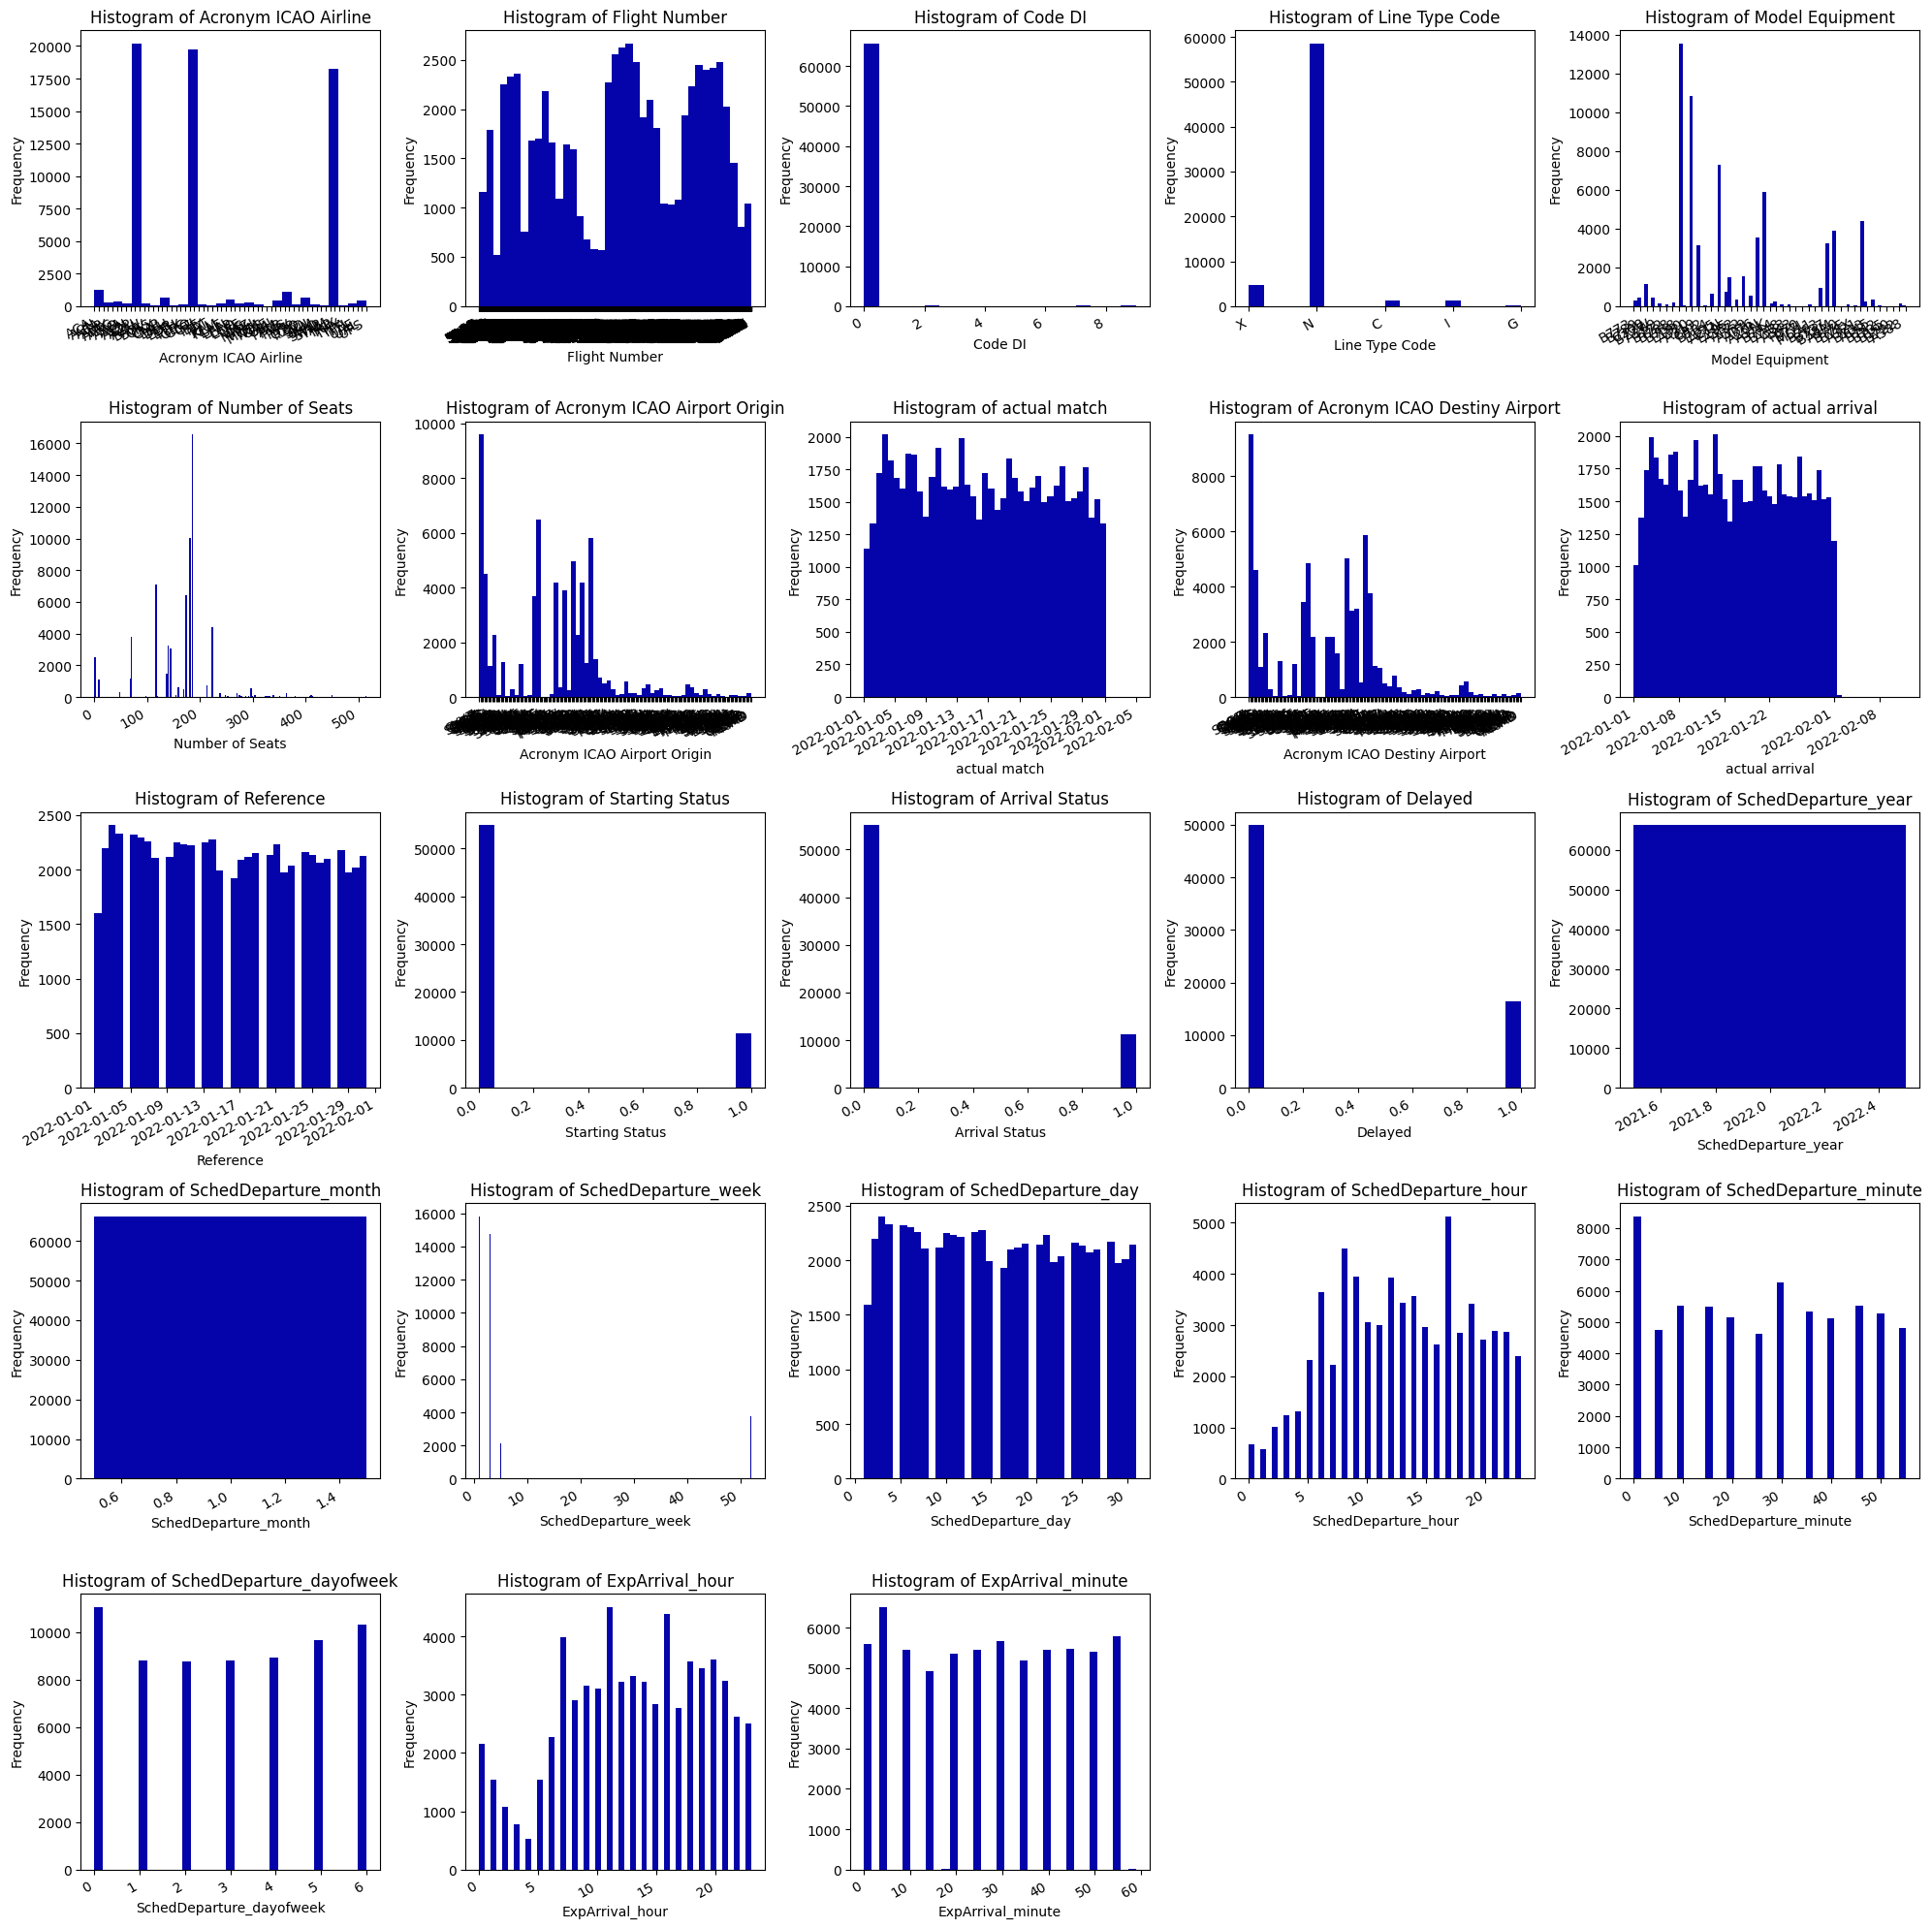

In [14]:
# Reform columns to correct data type
data_brazil4["Flight Number"] = data_brazil4["Flight Number"].astype(str)
data_brazil4["Arrival Status"] = data_brazil4["Arrival Status"].astype(int)
data_brazil4["Starting Status"] = data_brazil4["Starting Status"].astype(int)

# Plot histograms for each column
fig, axs = plt.subplots(5,5, figsize=(20,20))
axs[4,3].axis('off')
axs[4,4].axis('off')
x = 0; y = 0
for i, name in enumerate(data_brazil4.columns.values):
    if i % 5 == 0 and i != 0:
        y = 0
        x += 1
    axs[x,y].hist(x=data_brazil4[name], bins='auto', color='#0504aa')
    axs[x,y].set(xlabel=name, ylabel="Frequency")
    axs[x,y].set_title("Histogram of " + name)
    plt.setp(axs[x,y].get_xticklabels(), rotation=30, ha='right')
    y+=1
fig.tight_layout()
plt.show()

Most of the distributions are shown nicely and are really informative. For instance: it can be seen that a certain number of seats occurs a lot of times and that flights departuring in the night are less common. Further, the most frequent line type code is by far N, which represents domestic air passenger or mixed transport operations. Line type code X is not described in the dataset description, but I assume it is either unknown or a mix of multiple codes. Some of the columns like the airline and origin airport are not so clear since they have a broad scale. Therefore, the top 10 values of all columns will also be plotted in a histogram.

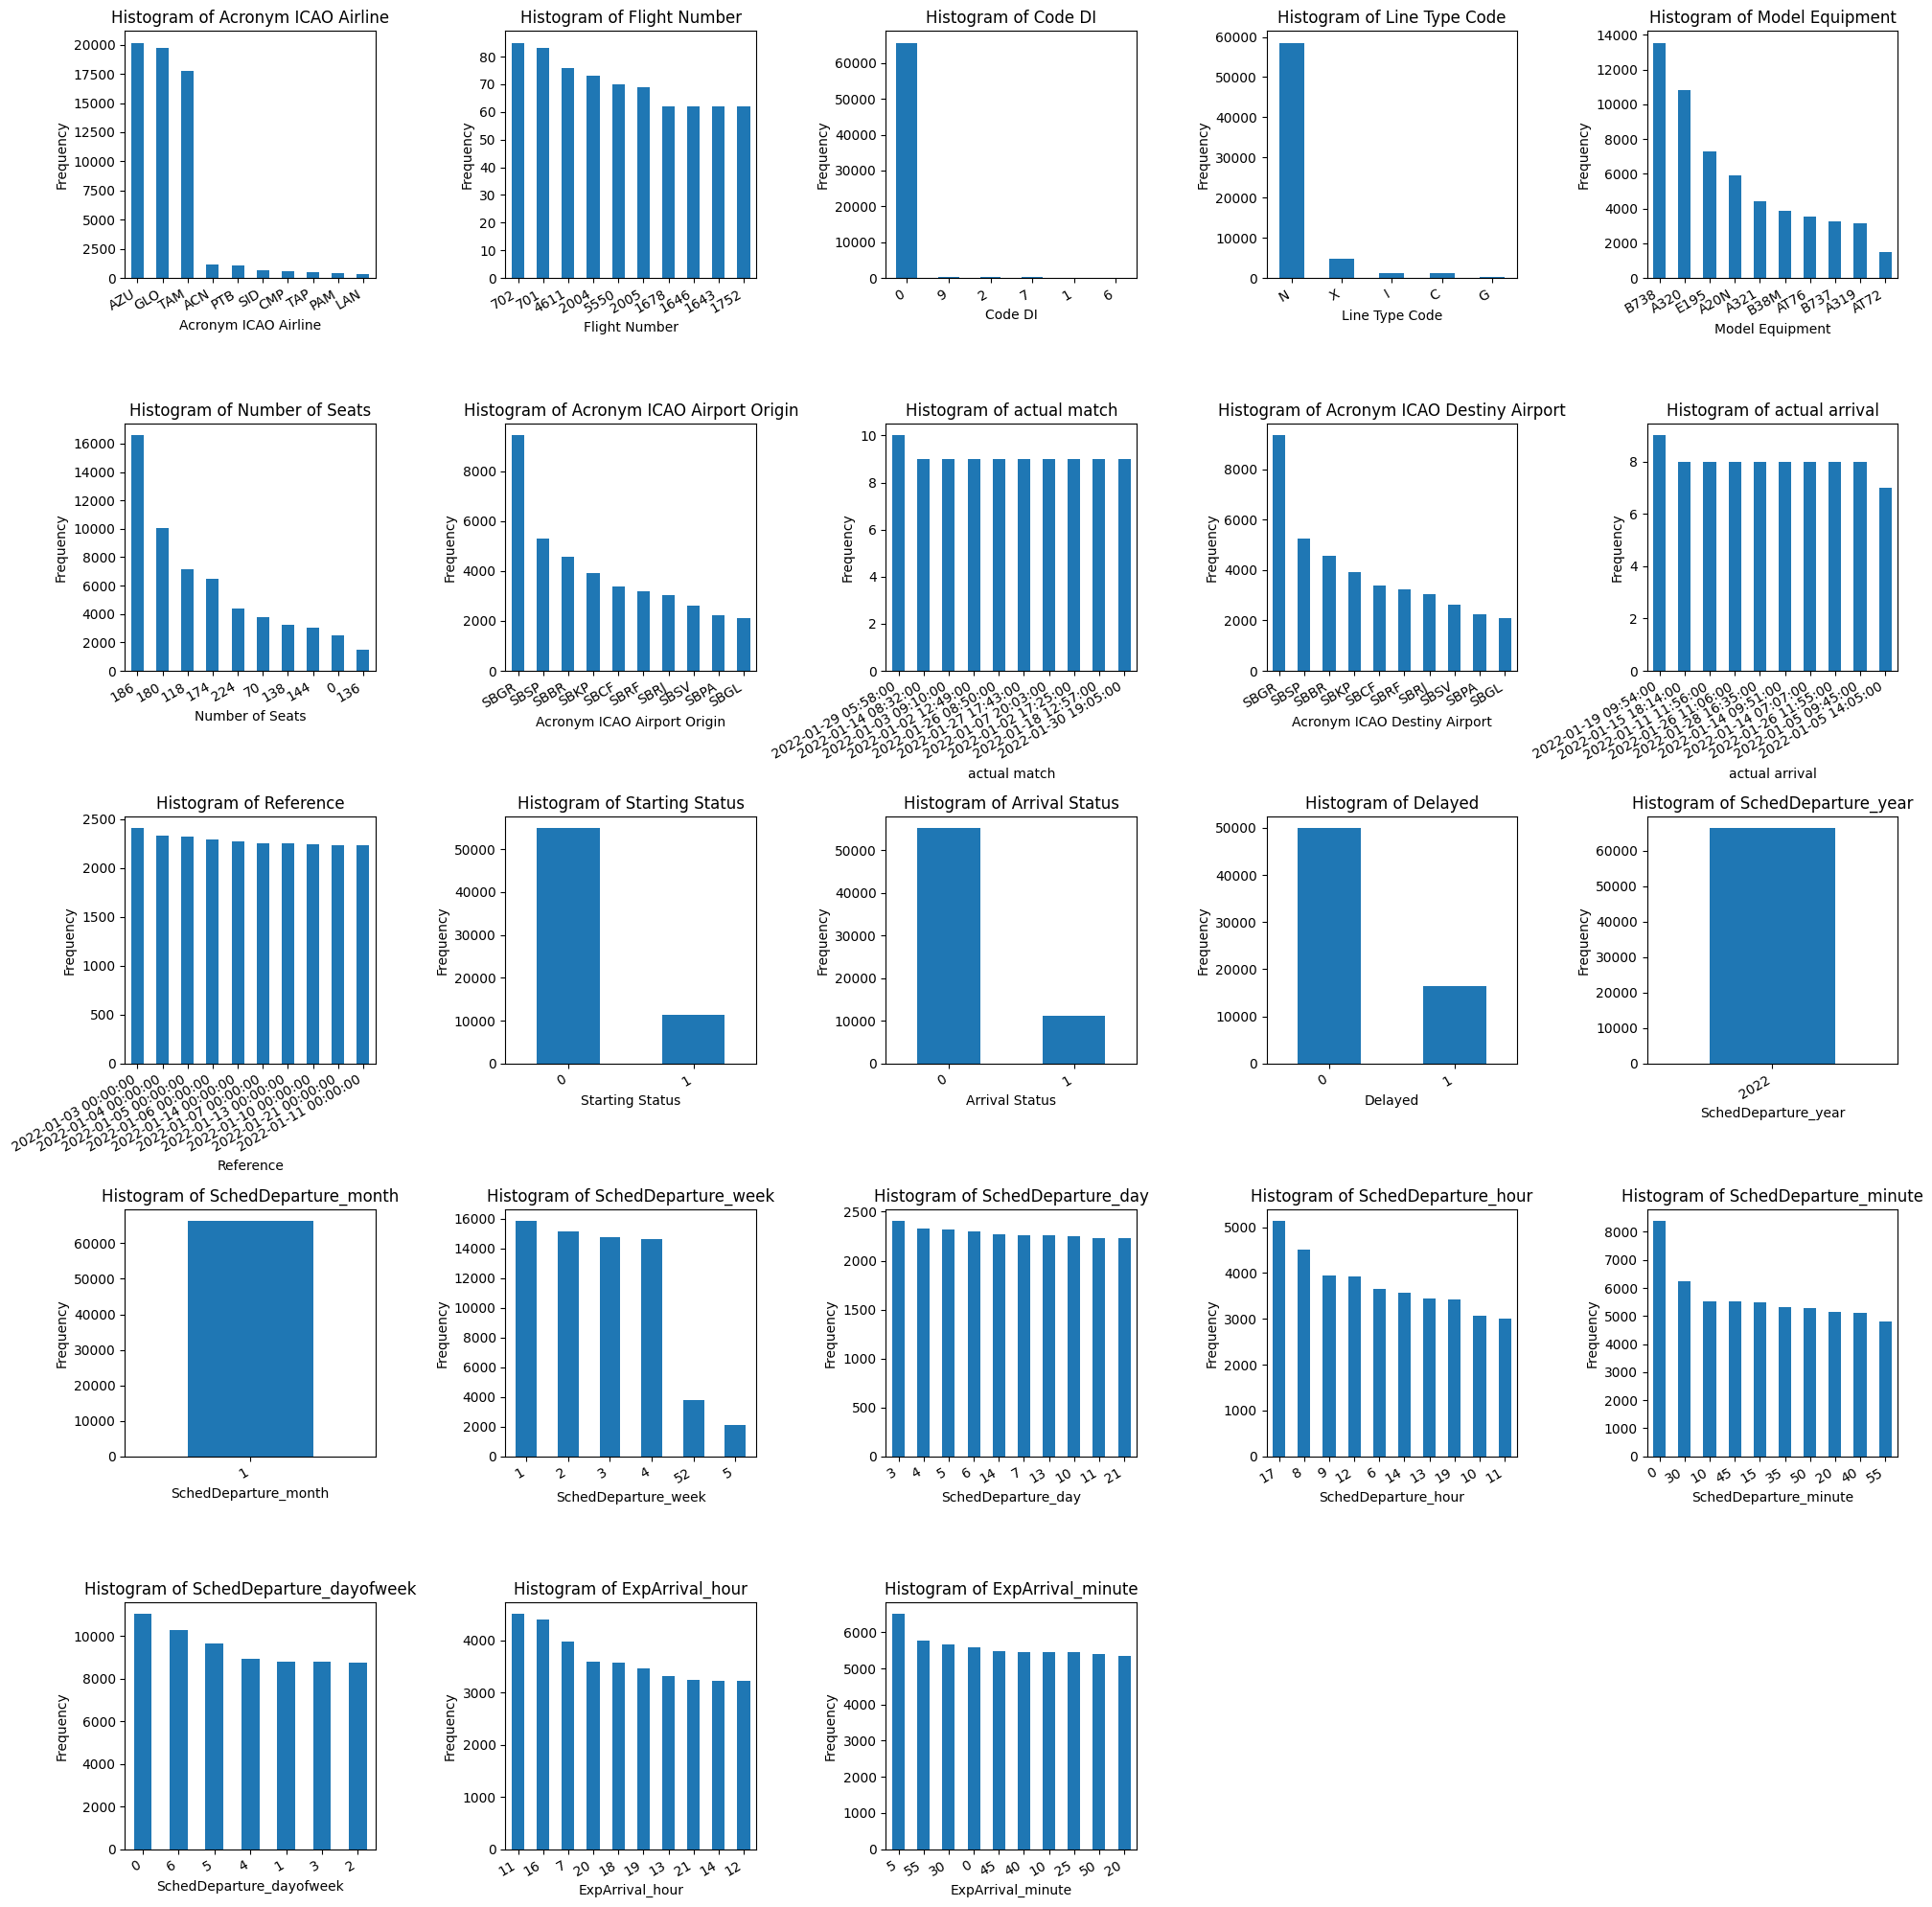

In [15]:
#  Plot histograms for each column, descending the top 10 occuring values for each column
fig, axs = plt.subplots(5,5, figsize=(20,20))
axs[4,3].axis('off')
axs[4,4].axis('off')
x = 0; y = 0
for i, name in enumerate(data_brazil4.columns.values):
    if i % 5 == 0 and i != 0:
        y = 0
        x += 1
    data_brazil4[name].value_counts().head(10).plot(kind='bar', ax=axs[x,y])
    axs[x,y].set(xlabel=name, ylabel="Frequency")
    axs[x,y].set_title("Histogram of " + name)
    plt.setp(axs[x,y].get_xticklabels(), rotation=30, ha='right')
    y+=1
fig.tight_layout()
plt.show()

In [16]:
print("Most frequent airlines: " + airline_code_dict.get("AZU") + ", " + airline_code_dict.get("GLO") + ", and " + airline_code_dict.get("TAM"))
print("Most frequent departure and arrival airports: " + airport_code_dict.get("SBGR") + ", " + airport_code_dict.get("SBSP") + ", and " + airport_code_dict.get("SBBR"))

Most frequent airlines: AZUL LINHAS AÉREAS BRASILEIRAS S/A, GOL LINHAS AÉREAS S.A. (EX- VRG LINHAS AÉREAS S.A.), and TAM LINHAS AÉREAS S.A.
Most frequent departure and arrival airports: GUARULHOS - GOVERNOR ANDRÉ FRANCO MONTORO - GUARULHOS - SP - BRAZIL, CONGONHAS - SÃO PAULO - SP - BRAZIL, and PRESIDENT JUSCELINO KUBITSCHEK - BRASÍLIA - DF - BRAZIL


A lot more information can be gathered from these obtained histograms. It can be seen that some airlines and airports are used way more often in Brazil than others. Further, the B738 model of plane is the most common and 186/180 seats is also a popular amount for flights in Brazil.

In this study, we are interested in flight delays. Therefore, we will look at the same distributions but then with the portion of delayed flights integrated in the histograms.

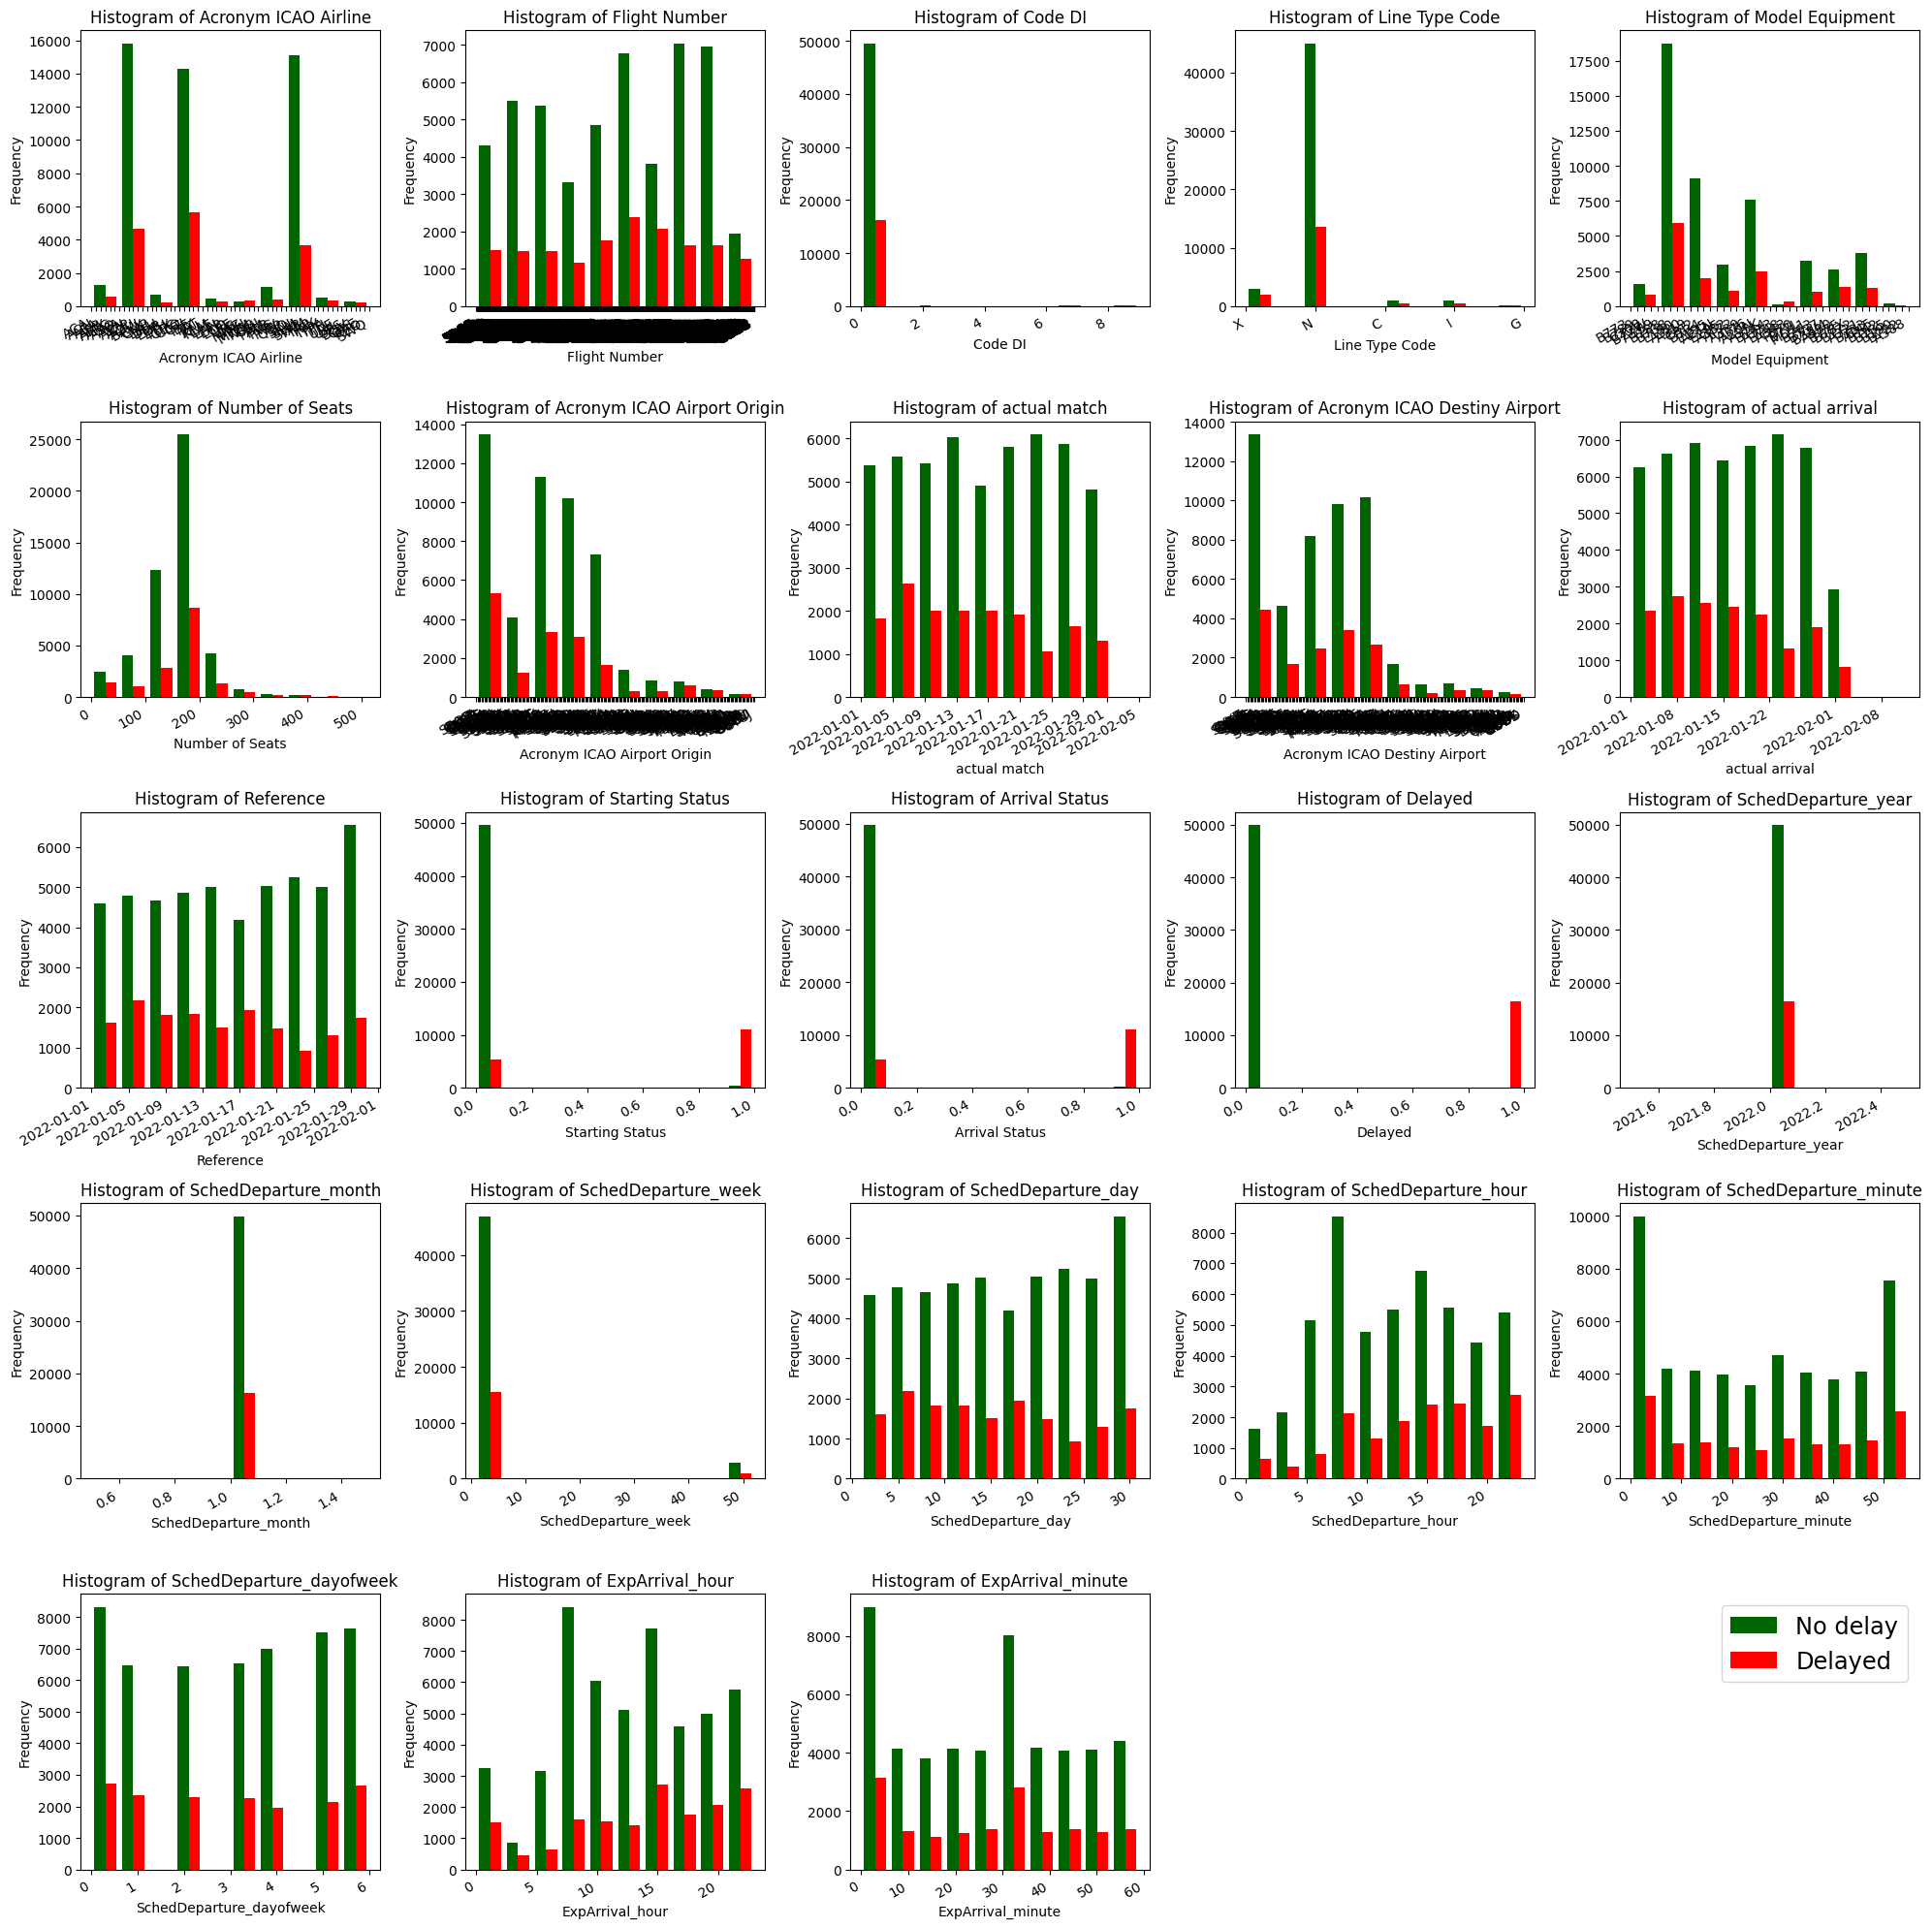

In [17]:
# Plot histograms for each column and making a separation between a delayed or non-delayed flight
fig, axs = plt.subplots(5,5, figsize=(20,20))
axs[4,3].axis('off')
axs[4,4].axis('off')
x = 0; y = 0
for i, name in enumerate(data_brazil4.columns.values):
    if i % 5 == 0 and i != 0:
        y = 0
        x += 1
    axs[x,y].hist([data_brazil4.loc[data_brazil4["Delayed"]==0, name], data_brazil4.loc[data_brazil4["Delayed"]==1, name]], color=["darkgreen", "red"], label=["No delay", "Delayed"])
    axs[x,y].set(xlabel=name, ylabel="Frequency")
    axs[x,y].set_title("Histogram of " + name)
    plt.setp(axs[x,y].get_xticklabels(), rotation=30, ha='right')
    handles, labels = axs[x,y].get_legend_handles_labels()
    y+=1
fig.tight_layout()
plt.legend(handles, labels, fontsize="xx-large")
plt.show()

The same will be done for the top 10 occuring values for each variable.

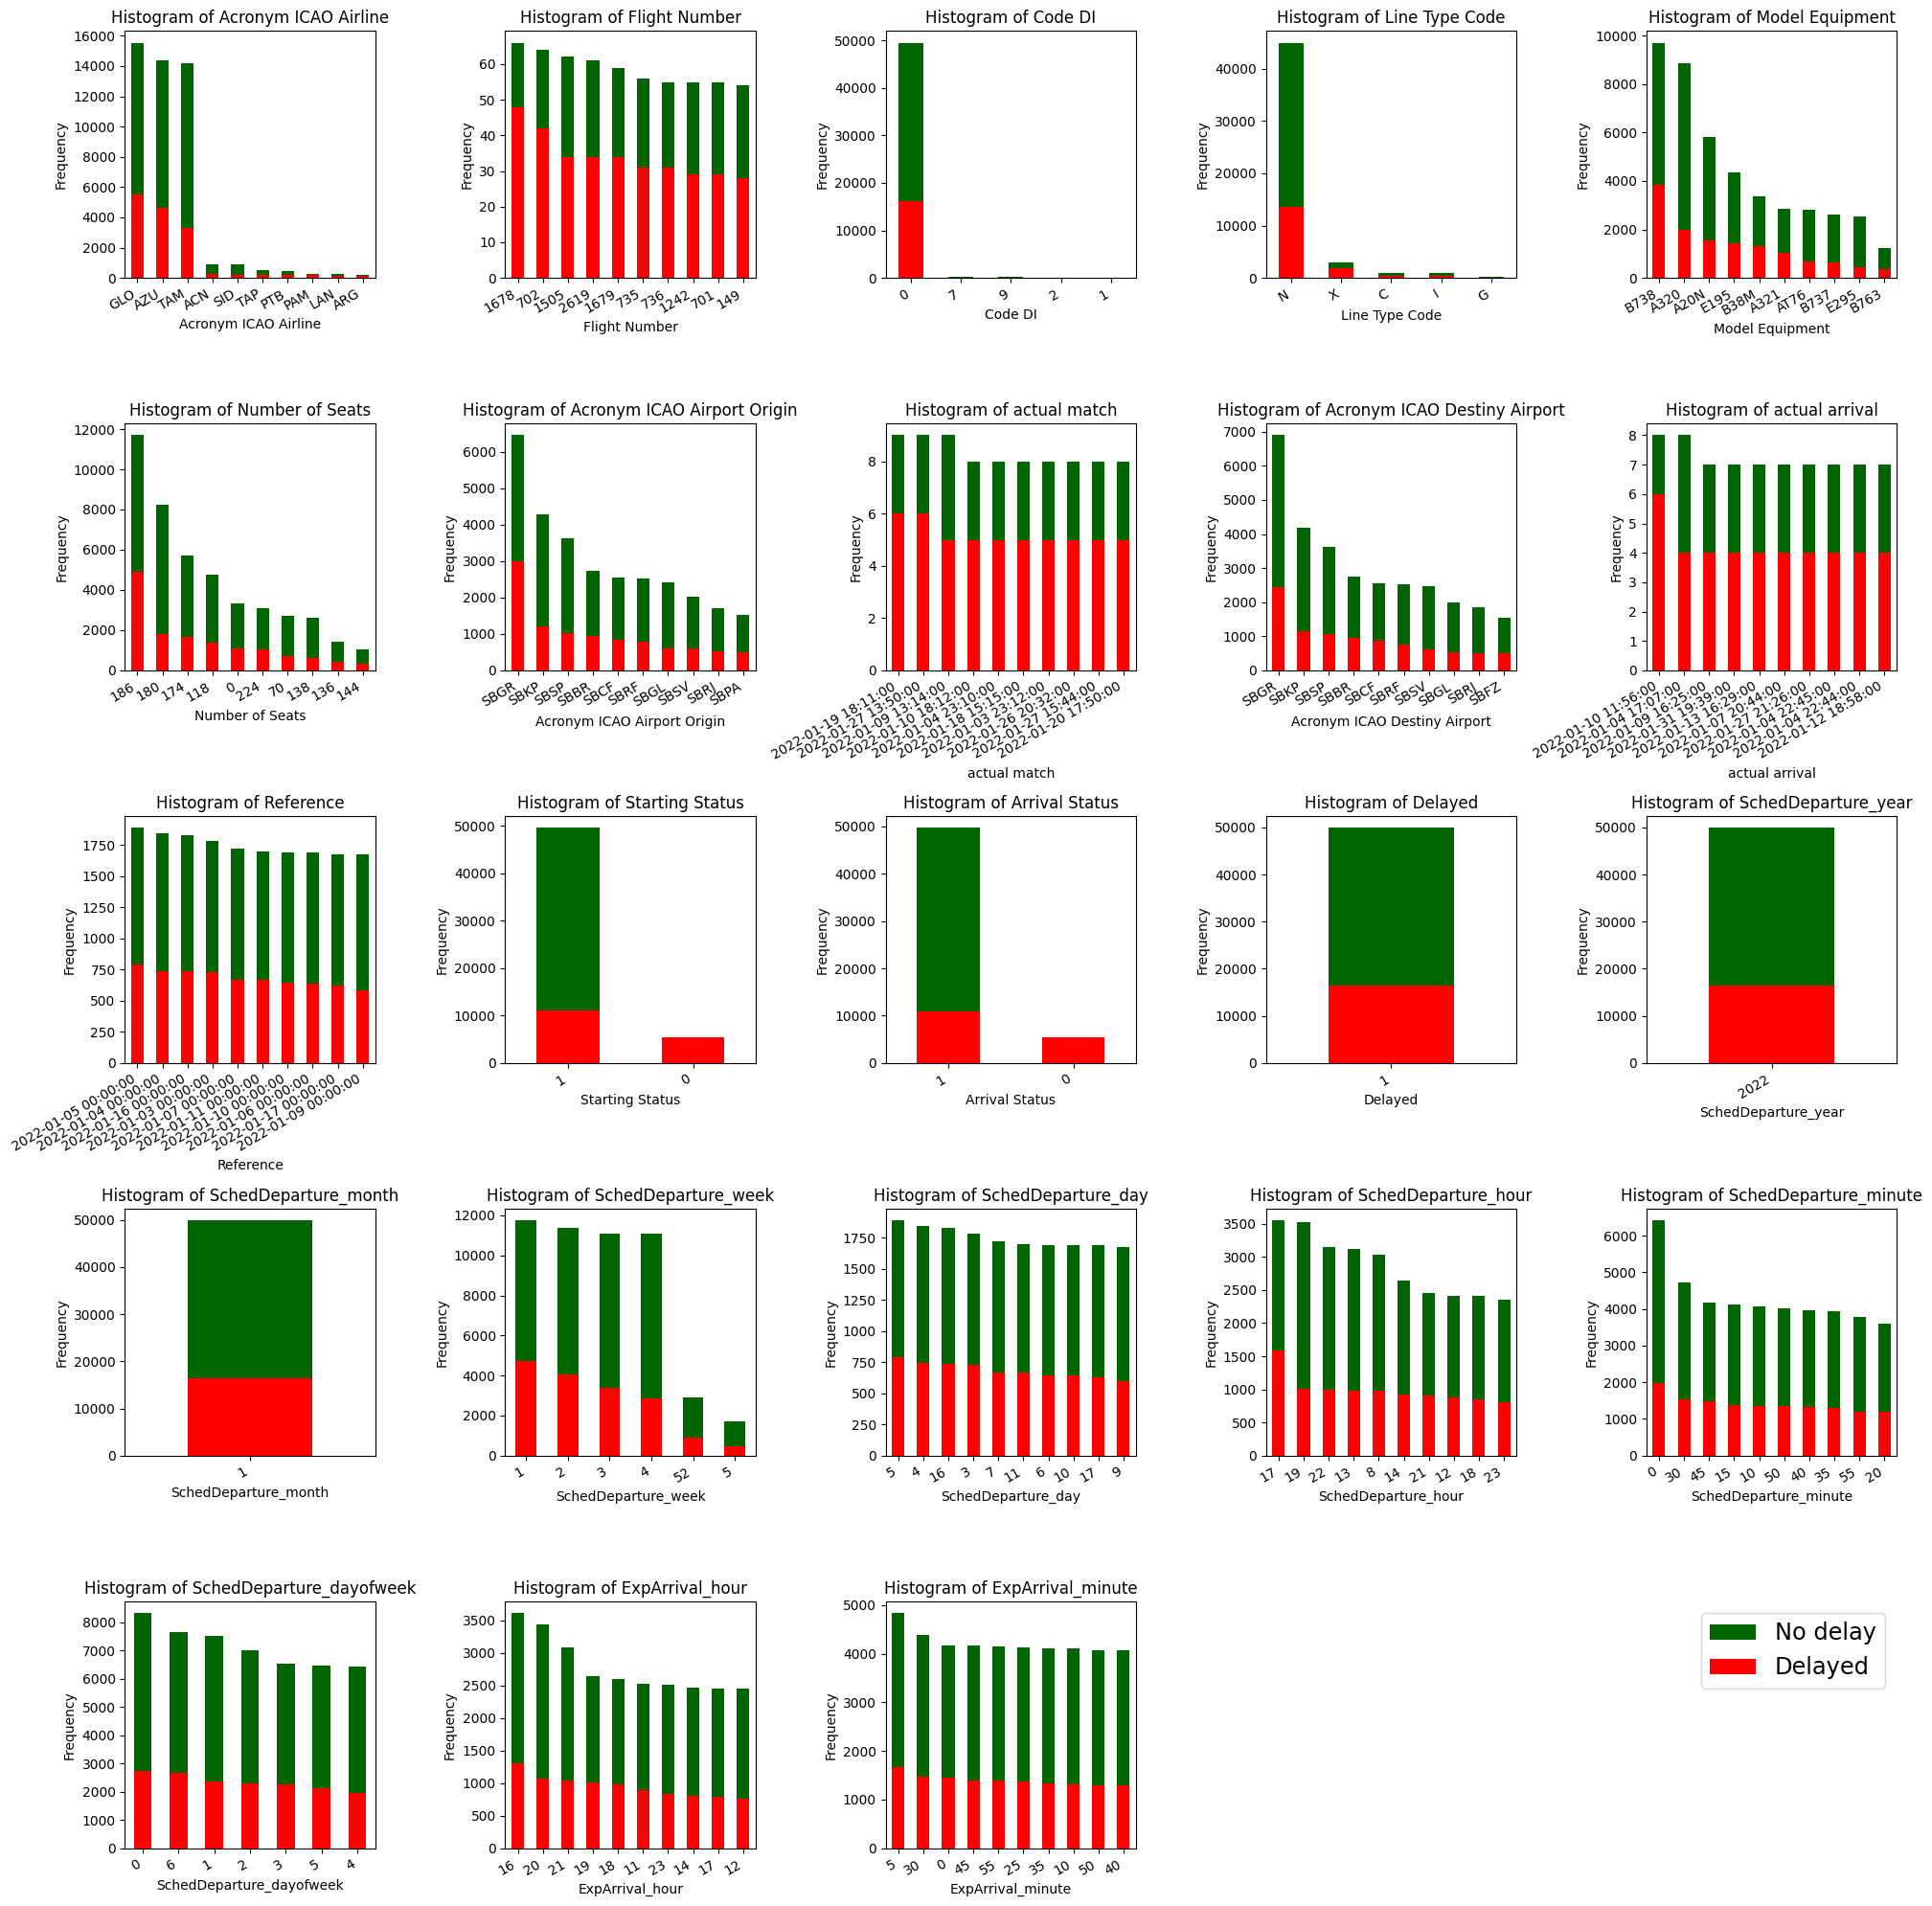

In [18]:
#  Plot histograms for each column, descending the top 10 occuring values for each column and making a separation between a delayed or non-delayed flight
fig, axs = plt.subplots(5,5, figsize=(20,20))
axs[4,3].axis('off')
axs[4,4].axis('off')
x = 0; y = 0
for i, name in enumerate(data_brazil4.columns.values):
    if i % 5 == 0 and i != 0:
        y = 0
        x += 1
    data_brazil4.loc[data_brazil4["Delayed"]==0, name].value_counts().head(10).plot(kind='bar', ax=axs[x,y], color='darkgreen', label="No delay")
    data_brazil4.loc[data_brazil4["Delayed"]==1, name].value_counts().head(10).plot(kind='bar', ax=axs[x,y], color='red', label="Delayed")
    axs[x,y].set(xlabel=name, ylabel="Frequency")
    axs[x,y].set_title("Histogram of " + name)
    plt.setp(axs[x,y].get_xticklabels(), rotation=30, ha='right')
    handles, labels = axs[x,y].get_legend_handles_labels()
    y+=1
fig.tight_layout()
plt.legend(handles, labels, fontsize="xx-large")
plt.show()

From the new histograms that take our response variable into account, we can see that the B738 also experiences a lot more delays than the other airplanes. We will also create boxplots to identify outliers and to create another way of looking at numerical data.

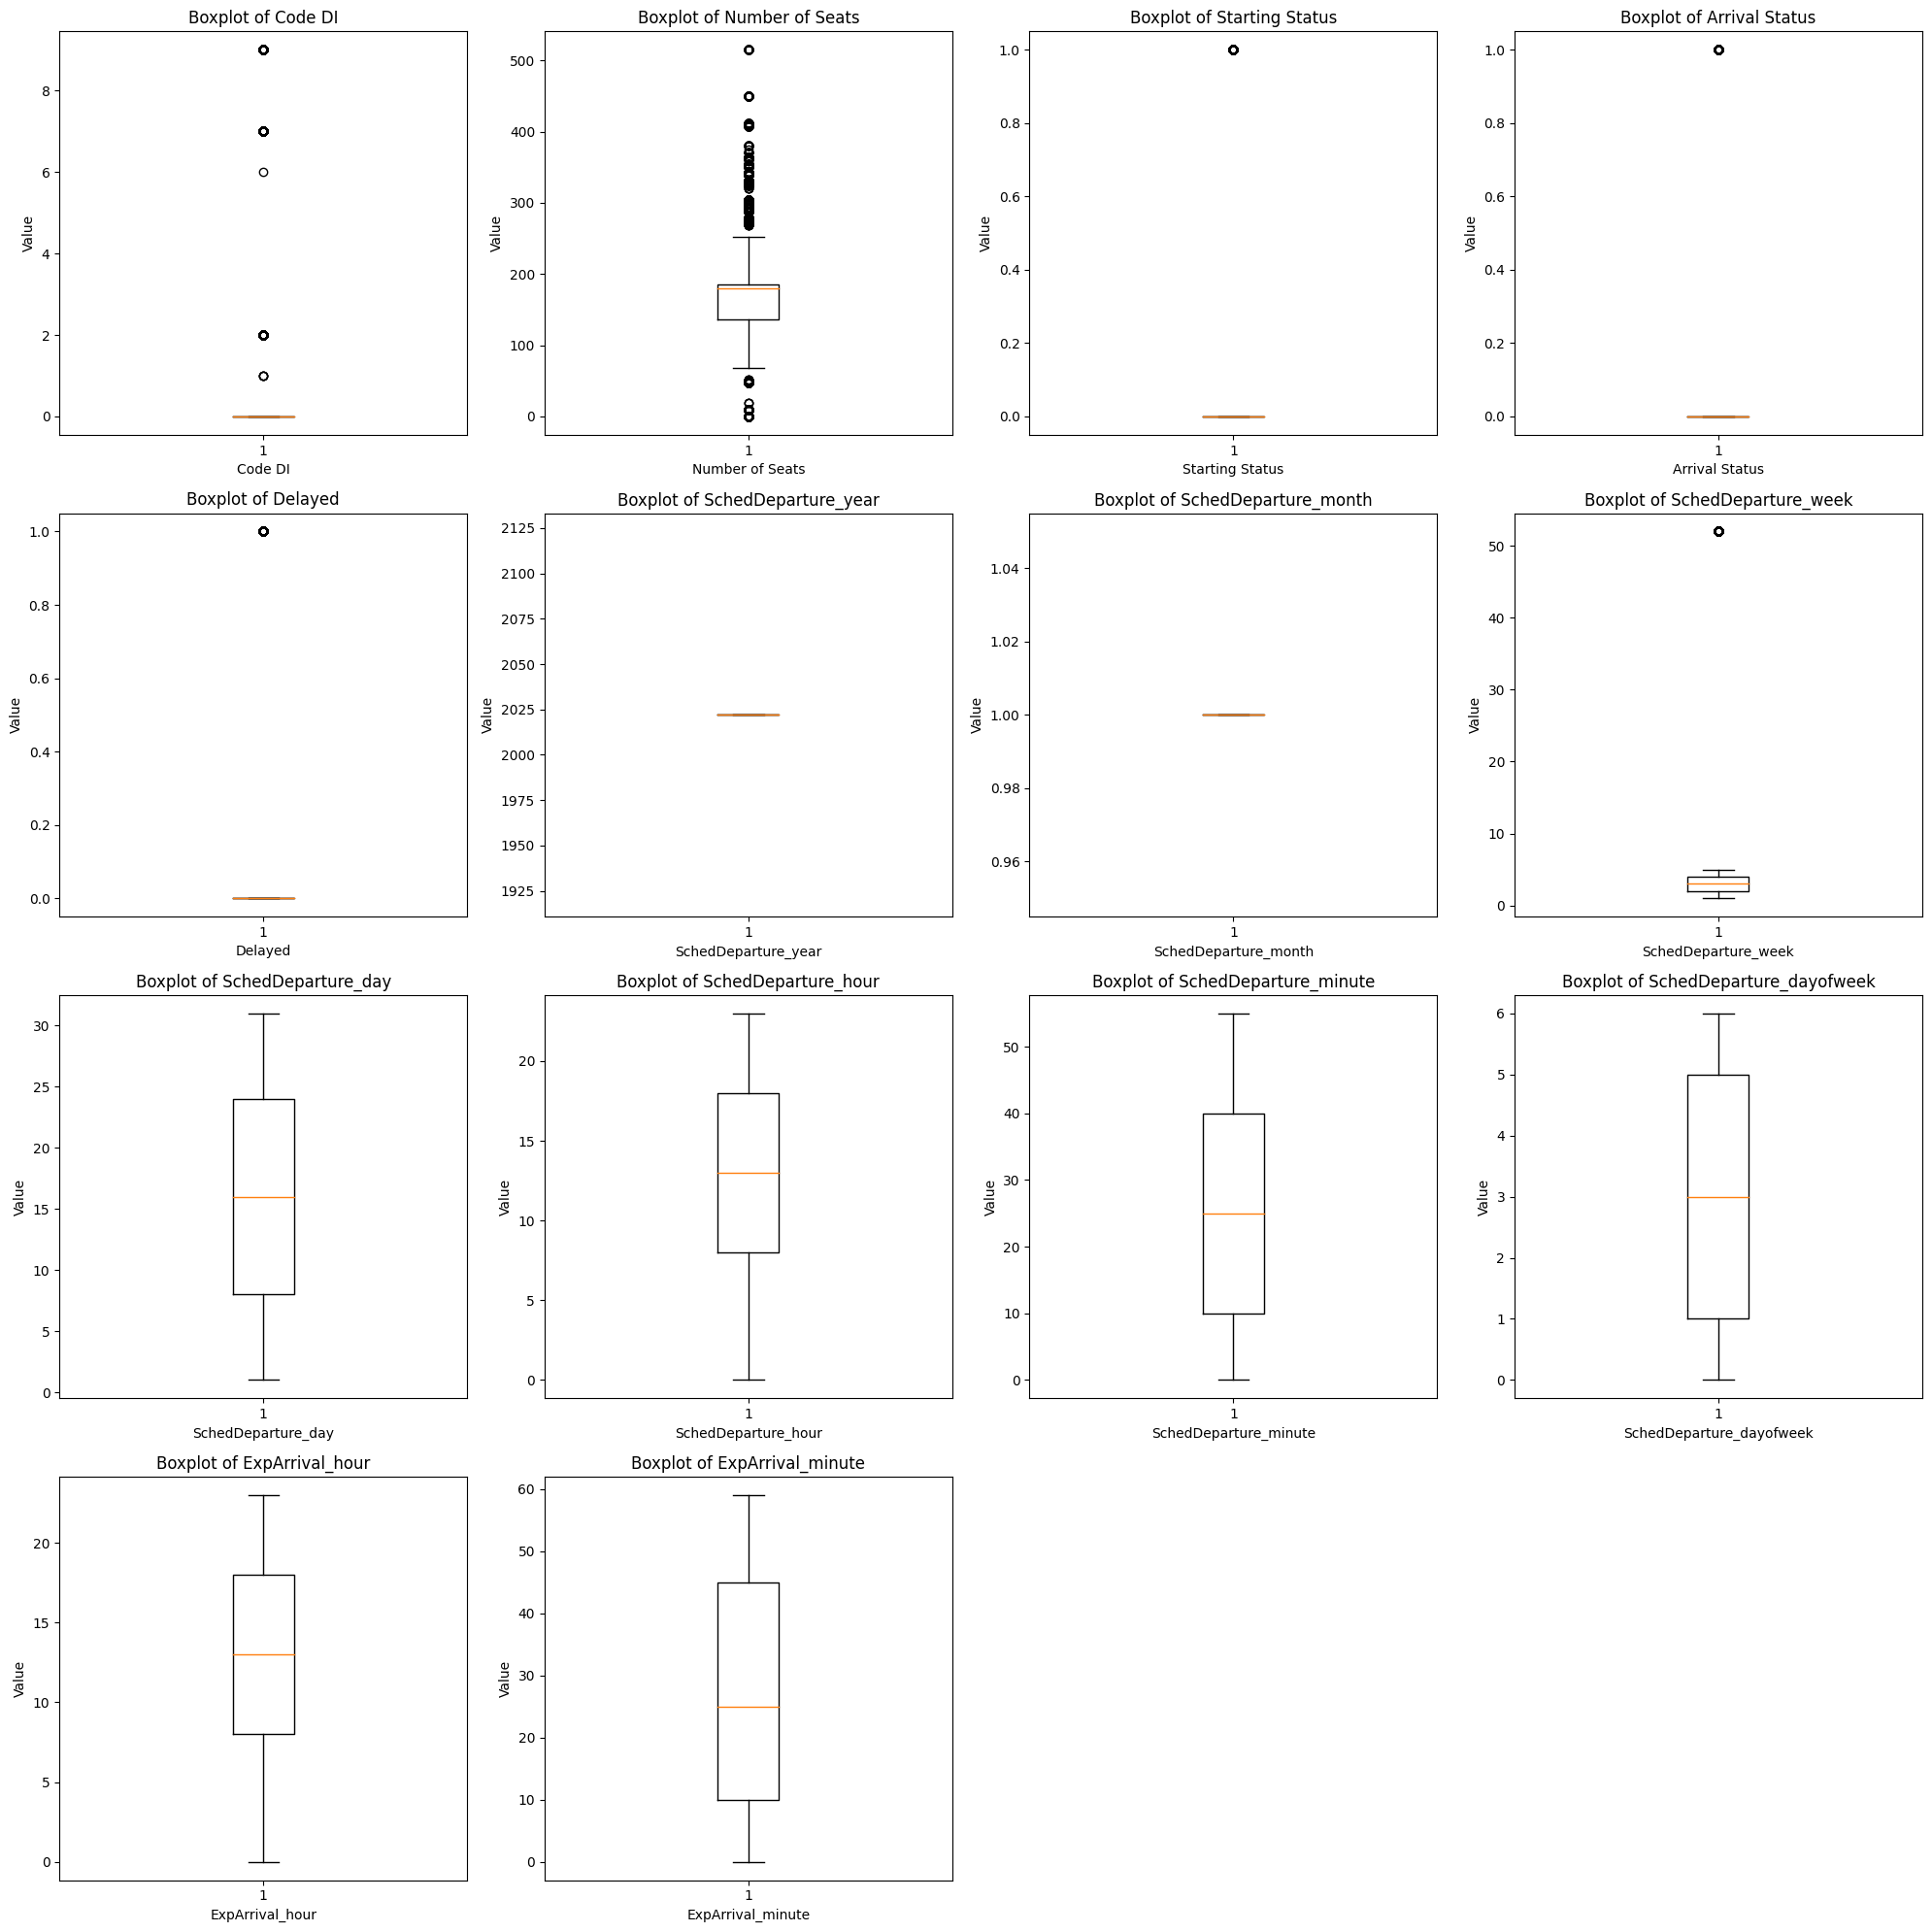

In [19]:
# Plot boxplots for numeric columns
fig, axs = plt.subplots(4,4, figsize=(20,20))
axs[3,2].axis('off')
axs[3,3].axis('off')
x = 0; y=0; count=0
for i, name in enumerate(data_brazil4.columns.values):
    if is_numeric_dtype(data_brazil4[name]):
        if count % 4 == 0 and count != 0:
            x += 1
            y = 0
        axs[x,y].boxplot(x=data_brazil4[name])
        axs[x,y].set(xlabel=name, ylabel="Value")
        axs[x,y].set_title("Boxplot of " + name)
        count +=1
        y += 1
fig.tight_layout()
plt.show()

From the histograms and boxplots, the distribution of each column is clearly visible. We can see that the 'Code DI' column is higly zero-inflated, and therefore seems to be redundant. The column will be removed because of this. It represents the type of authorization for each flight step and doesn't seem to have lots of effect on a delay. There are a lot of outliers visible in the number of seats column, but these won't get removed since there are planes with 0 seats (cargo planes) and with 500 seats (A388). 

In [20]:
# Drop Code DI column as it is highly zero-inflated
data_brazil4.drop(columns=['Code DI'], inplace=True)

Before going to feature selection, the columns 'actual match' and 'actual arrival' will be removed since this information is not known prior to the flight, and the prediction will be done prior to the flight. The 'Reference' column will also be removed, as the date can be derived from the 'Scheduled departure' fields.

In [32]:
# Remove columns that are unavailable at time of prediction
data_brazil5 = data_brazil4.drop(columns=['actual match', 'actual arrival', 'Reference'])

# Create copies of dataset to use for feature selection and ML algorithms
data_brazil_fs = data_brazil4.drop(columns=['actual match', 'actual arrival', 'Reference'])
data_brazil_ml = data_brazil4.drop(columns=['actual match', 'actual arrival', 'Reference'])

#### 2.4 Feature selection
We will now have a look at which features seem to be the most important for our problem. Firstly, to visualize the correlations between variables, a heatmap is created. This is done in order to detect high collinearity in our model.

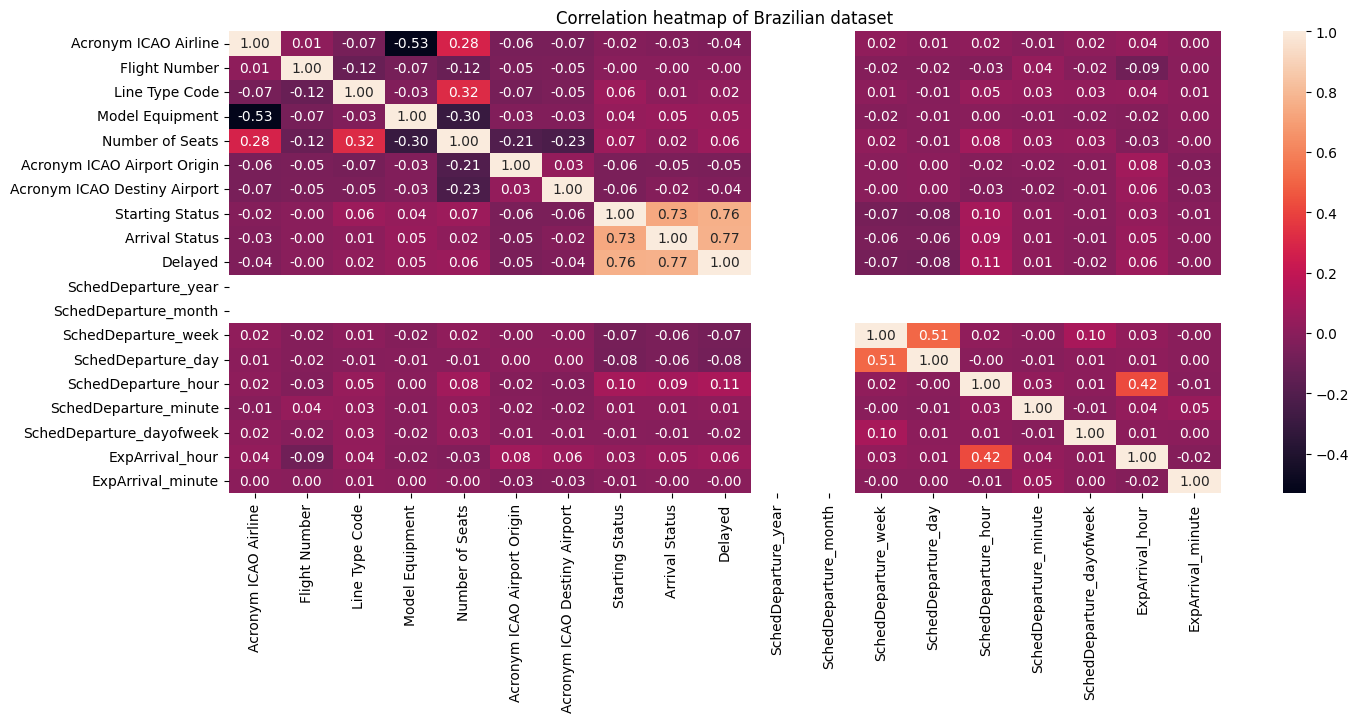

In [33]:
# Create correlation heatmap
for name in data_brazil5.columns.values:
    data_brazil5[name] = data_brazil5[name].astype('category').cat.codes
plt.figure(figsize=(16, 6))
plt.title("Correlation heatmap of Brazilian dataset")
heatmap = sns.heatmap(data_brazil5.corr(), annot=True, fmt=".2f")
plt.show()

Besides collinearity between the response variables, no signs of high collinearity (correlation >= 0.7 [source](https://doi.org/10.1111/j.1600-0587.2012.07348.x)) can be seen in this data set. Therefore, no columns have to be removed.

Another way to gain information about which features contain the most information is to perform a chi-square test and look at the mutual information gain.

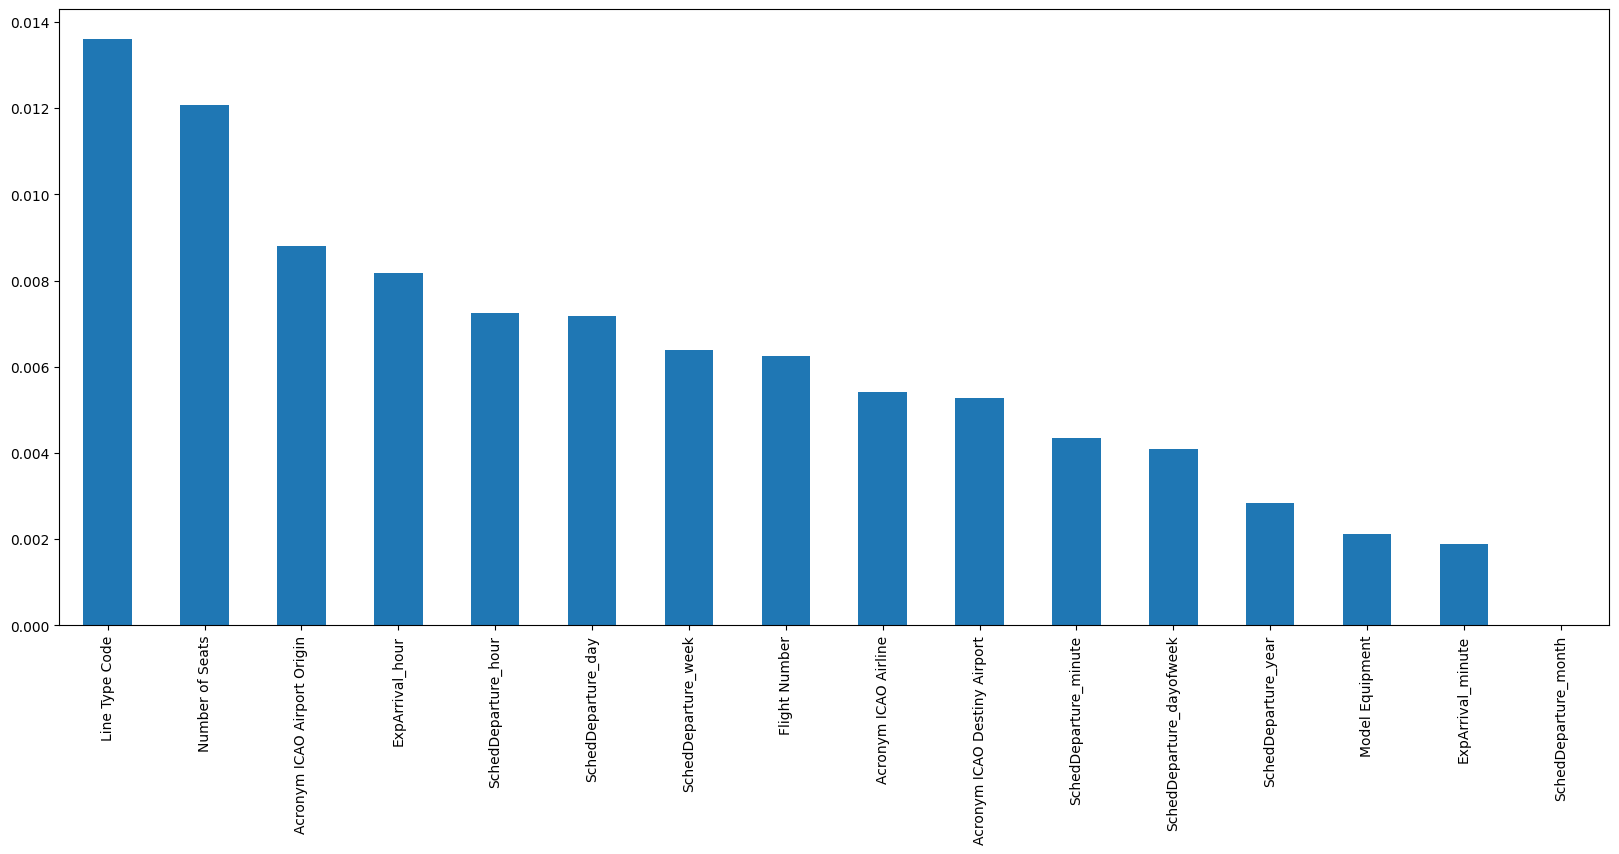

Index(['Line Type Code', 'Number of Seats', 'Acronym ICAO Airport Origin',
       'SchedDeparture_day', 'SchedDeparture_hour'],
      dtype='object')

In [50]:
# Create X and y of dataset
y = data_brazil5["Delayed"]
X = data_brazil5.drop(columns=["Delayed", "Arrival Status", "Starting Status"])

# Chi2 test
# f_p_values=chi2(X, y)
# p_values=pd.Series(f_p_values[1])
# p_values.index=X.columns
# print(p_values.sort_values(ascending=True))

# Calculate mutual information gain
mutual_info = mutual_info_classif(X,y)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))
plt.show()

from sklearn.feature_selection import SelectKBest
sel_five_cols = SelectKBest(mutual_info_classif, k=5)
sel_five_cols.fit_transform(X,y)
X.columns[sel_five_cols.get_support()]

The mutual information gain is a metric to get the importance of a variable. The higher the value, the more important that feature will be. In our case, we can see that the number of seats, line type code and the scheduled departure hour have the highest values. No columns will be removed, since we are only looking at one month of data yet.

The last metric used to see which features are more important than other is the information gain, which is calculated using the WoE. 

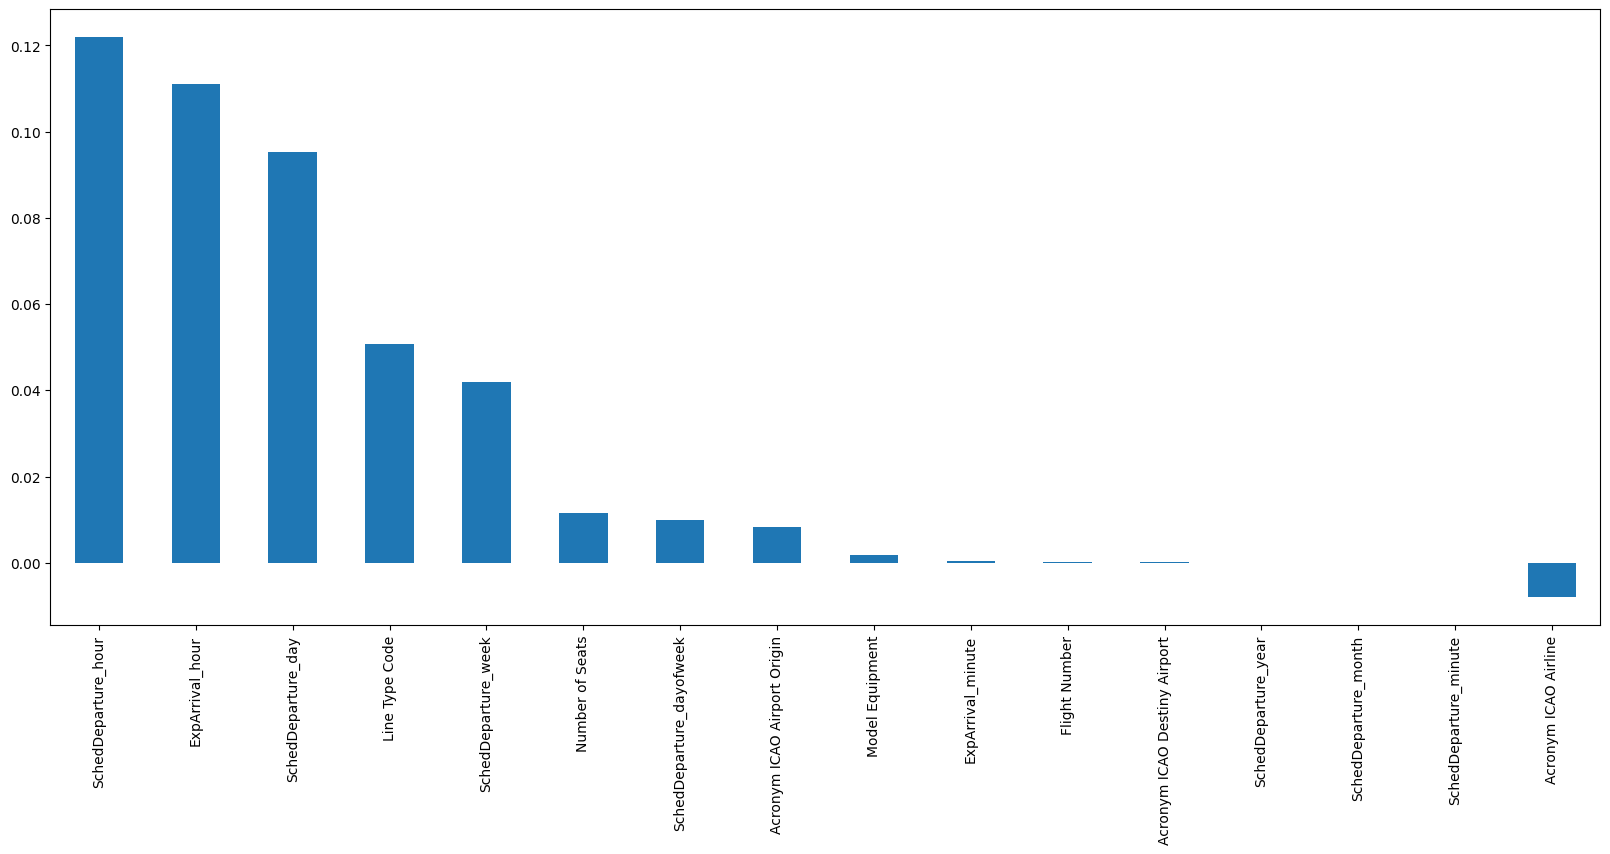

In [129]:
def get_iv(feature, target):
    df_woe_iv = (pd.crosstab(data_brazil_fs[feature],data_brazil_fs[target], normalize='columns')
                .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]) if (dfx[0]>0.0001).all() else dfx[1])
                .assign(iv=lambda dfx: np.sum(dfx['woe']*(dfx[1]-dfx[0]))))
    iv = df_woe_iv.iloc[0,2:][1]
    return iv

X_fs = data_brazil_fs.drop(columns=["Delayed", "Arrival Status", "Starting Status"])
ivs = []
for feature in X_fs.columns.values:
    ivs.append(get_iv(feature, "Delayed"))
ivs_pd = pd.Series(ivs)
ivs_pd.index = X_fs.columns
ivs_pd.sort_values(ascending=False).plot.bar(figsize=(20, 8))
plt.show()

The resulting plot of information values shows that all features have an IV below the useful threshold. However, this is caused due to the dataset being really diverse, which is the reason no variables will be removed yet.

The feature selection has shown some preliminary influences of various attributes. However, the predictions can use completely different factors as the crucial features, so these results are not to be fully taken representative.

#### 2.5 Machine learning

Now that the data exploration phase is done, all data will get encoded to make it ready for the machine learning algorithms. We are using One Hot Encoding instead of label encoding, to avoid confusing the model that there is some kind of hierarchy in the categorical columns and to keep the information in the model.

In [35]:
# USE scaling if needed

# Use One Hot Encoding (MAYBE USE LABEL ENCODING LATER)
# cols = data_brazil5.select_dtypes(include="object").columns.values
# data_brazil5 = pd.get_dummies(data_brazil5, columns=cols)

# from sklearn import tree
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split
# y = data_brazil5["Delayed"]
# X = data_brazil5.drop(columns=["Delayed", "Arrival Status", "Starting Status"])
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1242)
# clf = tree.DecisionTreeClassifier().fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# print(accuracy_score(y_test, y_pred))
# importance = pd.Series(clf.feature_importances_, index=X.columns.values)
# importance.sort_values(ascending=False).head(10).plot.bar()
# plt.show()
# plt.figure(figsize=(20,20))
# tree.plot_tree(clf, fontsize=10, feature_names=X.columns.values, class_names=['Delayed', 'No delay'])
# plt.show()